In [1]:
import os
import pandas as pd
import numpy as np
import sqlite3 as sql
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt

UOD = "/mnt/data/projects/precovery/precovery_data"
FRAME_DB = os.path.join(UOD, "index.db")
! du -sh {UOD}
! du -sh {FRAME_DB}

con = sql.connect(FRAME_DB)
frames = pd.read_sql("""SELECT * FROM frames""", con)
frame_analysis = pd.read_parquet("../uod/frame_analysis.parquet")
frames = frames.merge(frame_analysis, on="id")
frames.insert(2, "month", frames["data_uri"].str.split("/").str[1])

300G	/mnt/data/projects/precovery/precovery_data
888M	/mnt/data/projects/precovery/precovery_data/index.db


In [2]:
frames.head(10)

,id,dataset_id,month,obscode,exposure_id,filter,exposure_mjd_start,exposure_mjd_mid,exposure_duration,healpixel,...,num_obs,mag_mean,mag_sigma,mag_p0,mag_p10,mag_p25,mag_p50,mag_p75,mag_p90,mag_p100
0,1,nsc,2019-11,W84,c4d_191104_000420_ooi_r_v1,r,58791.003015,58791.003594,100.0,7183,...,10,19.166800,1.014112,17.904034,17.947817,18.196552,19.203083,19.603692,20.710082,20.918606
1,2,nsc,2019-11,W84,c4d_191104_000420_ooi_r_v1,r,58791.003015,58791.003594,100.0,7216,...,84,18.487522,1.229219,15.675141,16.659373,17.745076,18.594448,19.423680,20.076396,20.664434
2,3,nsc,2019-11,W84,c4d_191104_000420_ooi_r_v1,r,58791.003015,58791.003594,100.0,7194,...,13,18.559338,1.008222,16.876226,17.306288,17.951609,18.419567,19.121113,19.682833,20.635878
3,4,nsc,2019-11,W84,c4d_191104_000420_ooi_r_v1,r,58791.003015,58791.003594,100.0,7205,...,103,18.915774,1.162890,15.005179,17.522037,18.298101,18.792004,19.743952,20.609078,21.501453
4,5,nsc,2019-11,W84,c4d_191104_001228_ooi_g_v1,g,58791.008662,58791.009820,200.0,7194,...,1249,20.342707,1.193451,13.122038,19.037251,19.818607,20.502851,21.112137,21.583053,22.629879
5,6,nsc,2019-11,W84,c4d_191104_001228_ooi_g_v1,g,58791.008662,58791.009820,200.0,7183,...,348,20.893473,0.870544,16.720928,19.694775,20.434043,20.990149,21.517511,21.840354,22.668045
6,7,nsc,2019-11,W84,c4d_191104_001228_ooi_g_v1,g,58791.008662,58791.009820,200.0,7192,...,108,20.392801,0.827184,17.432611,19.365046,19.986115,20.565914,20.931695,21.339226,21.856586
7,8,nsc,2019-11,W84,c4d_191104_001616_ooi_r_v1,r,58791.011306,58791.011885,100.0,7194,...,193,19.376288,0.929025,15.997598,18.293607,18.835772,19.411467,20.121828,20.472093,21.587795
8,9,nsc,2019-11,W84,c4d_191104_001616_ooi_r_v1,r,58791.011306,58791.011885,100.0,7183,...,52,19.845587,0.978440,16.149240,18.860884,19.238395,19.963988,20.598560,20.808226,21.747673
9,10,nsc,2019-11,W84,c4d_191104_001616_ooi_r_v1,r,58791.011306,58791.011885,100.0,7192,...,19,19.553085,0.994307,16.373060,18.865077,19.369908,19.876750,20.098672,20.309168,20.914960


We are looking to get an estimate for the number of test orbits we will need to process the entire NSC. 

$$ N_{TestOrbits} = ? $$


In [3]:
# Read benchmark results from the thor_experiments repo
benchmark_results = pd.read_csv("/home/moeyensj/projects/thor/thor_experiments/benchmarks/thor_results.csv")

# Calculate the total time for each benchmark
benchmark_results["total_time"] = (
    benchmark_results["projection_time"] 
    + benchmark_results["clustering_time"] 
    + benchmark_results["restructuring_time"] 
    + benchmark_results["iod_time"]
    + benchmark_results["od_time"]
    + benchmark_results["odp_time"]
)
benchmark_results["total_clustering_time"] = (benchmark_results["clustering_time"] + benchmark_results["restructuring_time"])

benchmark_results.head()

,cell_area,eps,alg,projection_time,projected_observations,clustering_time,restructuring_time,clusters,iod_time,iod_orbits,od_time,od_orbits,odp_time,odp_orbits,total_time,total_clustering_time
0,1.0,1.0,dbscan,27.007,11153,54.512,0.061,0,0.010,0,0.007,0.0,0.011,0.0,81.608,54.573
1,1.0,1.0,hotspot_2d,27.504,11153,28.377,0.038,0,0.009,0,0.007,0.0,0.010,0.0,55.945,28.415
2,1.0,5.0,dbscan,27.079,11153,54.247,0.138,80,5.113,56,7.078,7.0,53.103,7.0,146.758,54.385
3,1.0,5.0,hotspot_2d,26.066,11153,29.723,0.081,86,6.281,53,7.632,6.0,46.225,4.0,116.008,29.804
4,1.0,10.0,dbscan,28.083,11153,60.670,0.712,1240,7.272,820,47.850,13.0,57.528,10.0,202.115,61.382


In [4]:
time_cols = ["projection_time", "total_clustering_time", "iod_time", "od_time", "odp_time"]
num_cols = ["projected_observations", "clusters", "iod_orbits", "od_orbits", "odp_orbits"]

In [5]:
benchmark_results_dbscan = benchmark_results[benchmark_results["alg"] == "dbscan"]
benchmark_results_hotspot_2d = benchmark_results[benchmark_results["alg"] == "hotspot_2d"]

unique_eps = benchmark_results_dbscan["eps"].unique()
unique_cell_area = benchmark_results_dbscan["cell_area"].unique()

/tmp/ipykernel_224671/3445766505.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


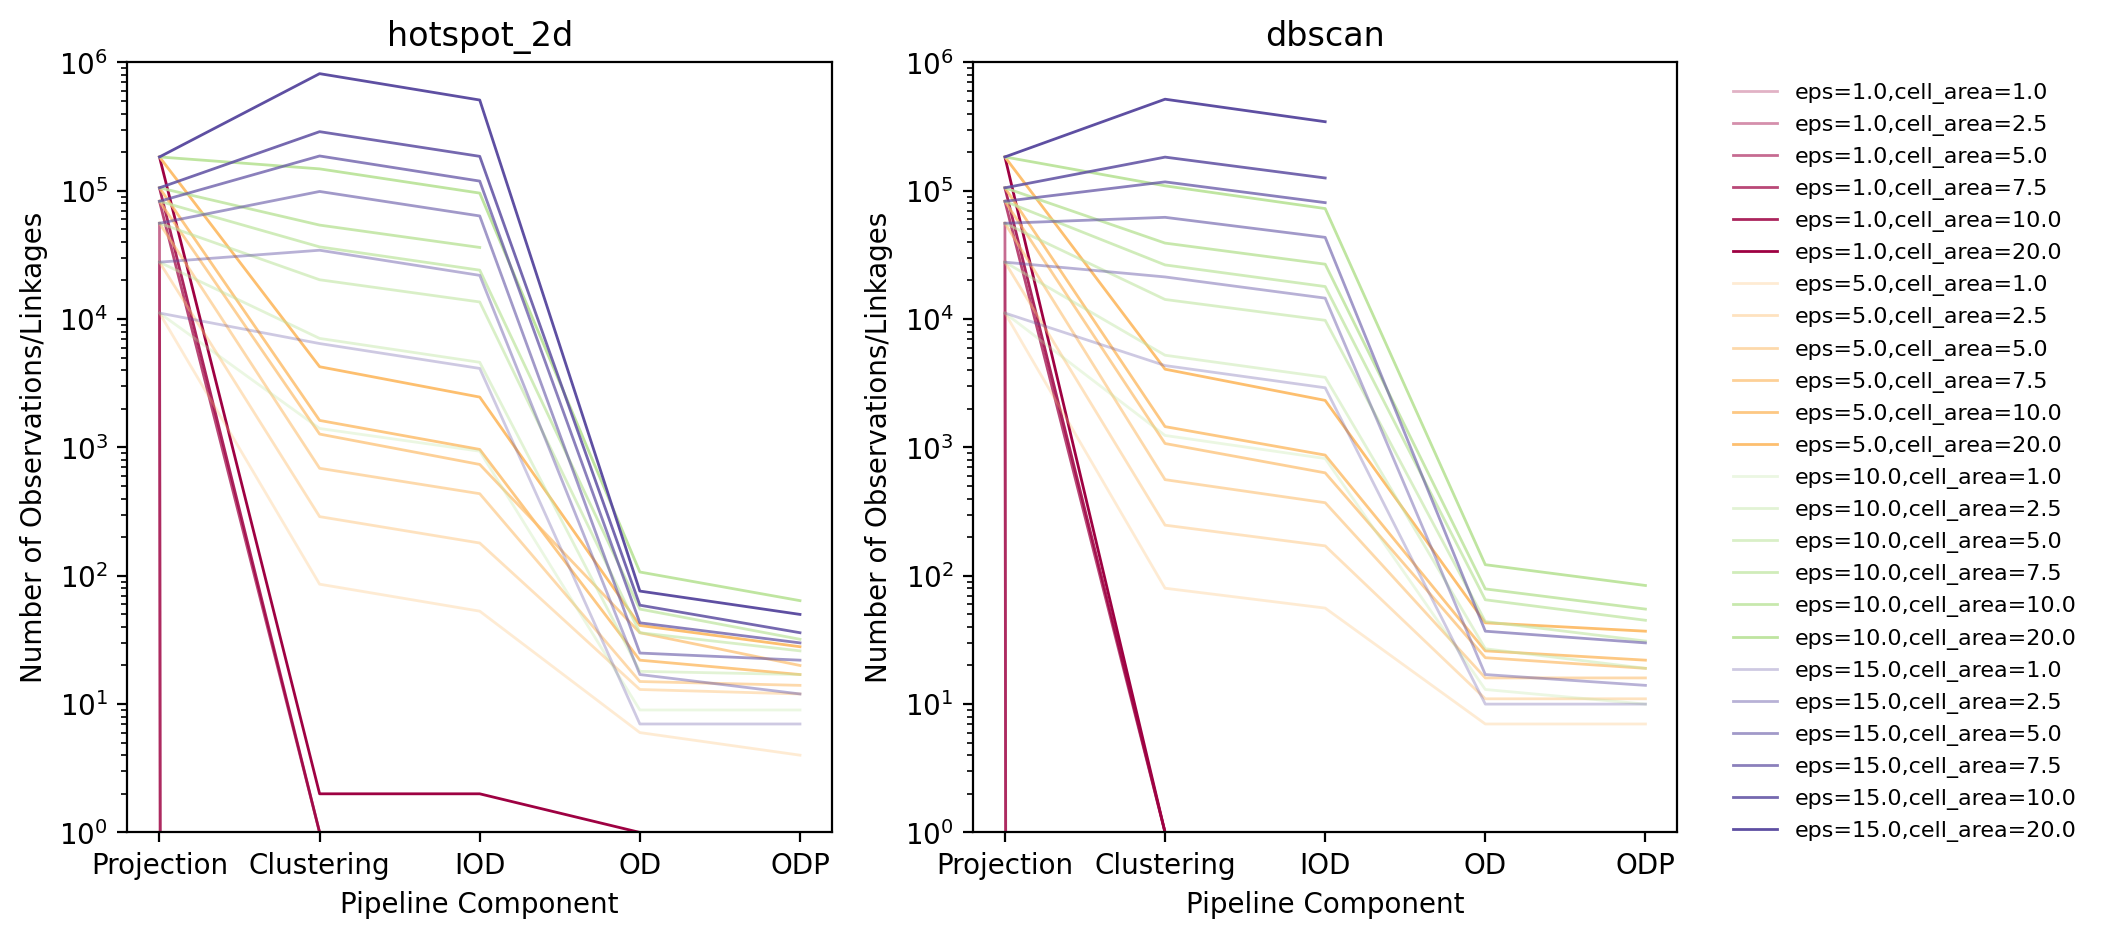

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
cmap = matplotlib.cm.get_cmap('Spectral')
rgba = cmap(np.linspace(0, 1, len(unique_eps)))
alpha_range = np.linspace(0.3, 1, len(unique_cell_area))

for i, eps in enumerate(unique_eps):
    for j, cell_area in enumerate(unique_cell_area):
        for k, alg in enumerate(["hotspot_2d", "dbscan"]):
            mask_i = (
                (benchmark_results['cell_area'] == cell_area) 
                & (benchmark_results["alg"] == alg) 
                & (benchmark_results['eps'] == eps)
            )

            if k == 1:
                label = f"eps={eps},cell_area={cell_area}"
            else:
                label = None

            ax[k].plot(
                np.arange(0, len(time_cols)), 
                benchmark_results[mask_i][num_cols].values[0], 
                label=label, 
                lw=1, 
                c=rgba[i], 
                alpha=alpha_range[j]
            )
            ax[k].set_title(alg)

for a in ax:
    a.set_xticks(np.arange(0, len(time_cols)))
    a.set_xticklabels(["Projection", "Clustering", "IOD", "OD", "ODP"])
    a.set_ylabel("Number of Observations/Linkages")
    a.set_xlabel("Pipeline Component")
    a.set_yscale("log")
    a.set_ylim(1, 1e6)

ax[1].legend(frameon=False, bbox_to_anchor=(1.05, 1), fontsize=8)
fig.savefig("plots/benchmarks_num_obs_linkages.jpg", bbox_inches="tight", dpi=200)

/tmp/ipykernel_224671/1183739380.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')
/tmp/ipykernel_224671/1183739380.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[j].scatter(


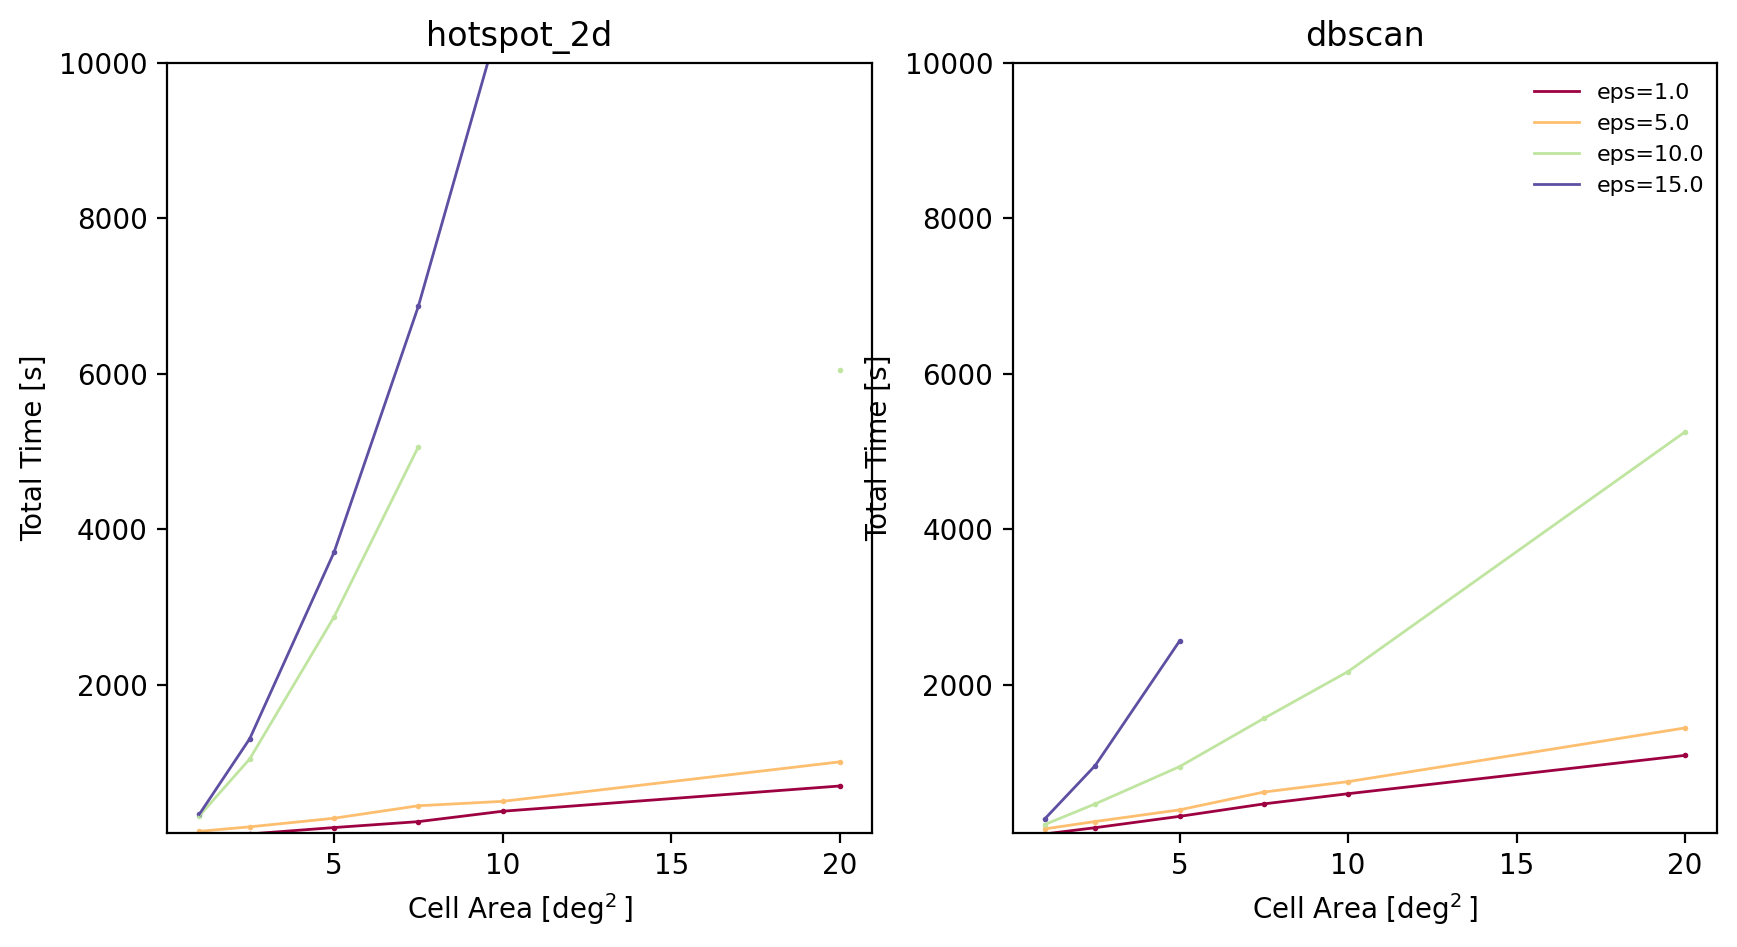

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
cmap = matplotlib.cm.get_cmap('Spectral')
rgba = cmap(np.linspace(0, 1, len(unique_eps)))
alpha_range = np.linspace(0.3, 1, len(unique_cell_area))

for i, eps in enumerate(unique_eps):
    for j, alg in enumerate(["hotspot_2d", "dbscan"]):
        mask_i = ((benchmark_results["alg"] == alg) 
            & (benchmark_results['eps'] == eps)
        )

        if j == 1:
            label = f"eps={eps}"
        else:
            label = None

        ax[j].scatter(
            benchmark_results[mask_i]["cell_area"].values, 
            benchmark_results[mask_i]["total_time"].values, 
            c=rgba[i], 
            s=1
        )
        ax[j].plot(
            benchmark_results[mask_i]["cell_area"].values, 
            benchmark_results[mask_i]["total_time"].values, 
            label=label, 
            c=rgba[i], 
            lw=1
        )
        ax[j].set_title(alg)

for a in ax:
    a.set_ylabel("Total Time [s]")
    a.set_xlabel("Cell Area [$\deg^2$]")
    #a.set_yscale("log")
    a.set_ylim(100, 10000)
ax[1].legend(frameon=False, bbox_to_anchor=(1.01, 1), fontsize=8)
fig.savefig("plots/benchmarks_total_time.png", bbox_inches="tight", dpi=200)

/tmp/ipykernel_224671/1167202855.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')
/tmp/ipykernel_224671/1167202855.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[j].scatter(


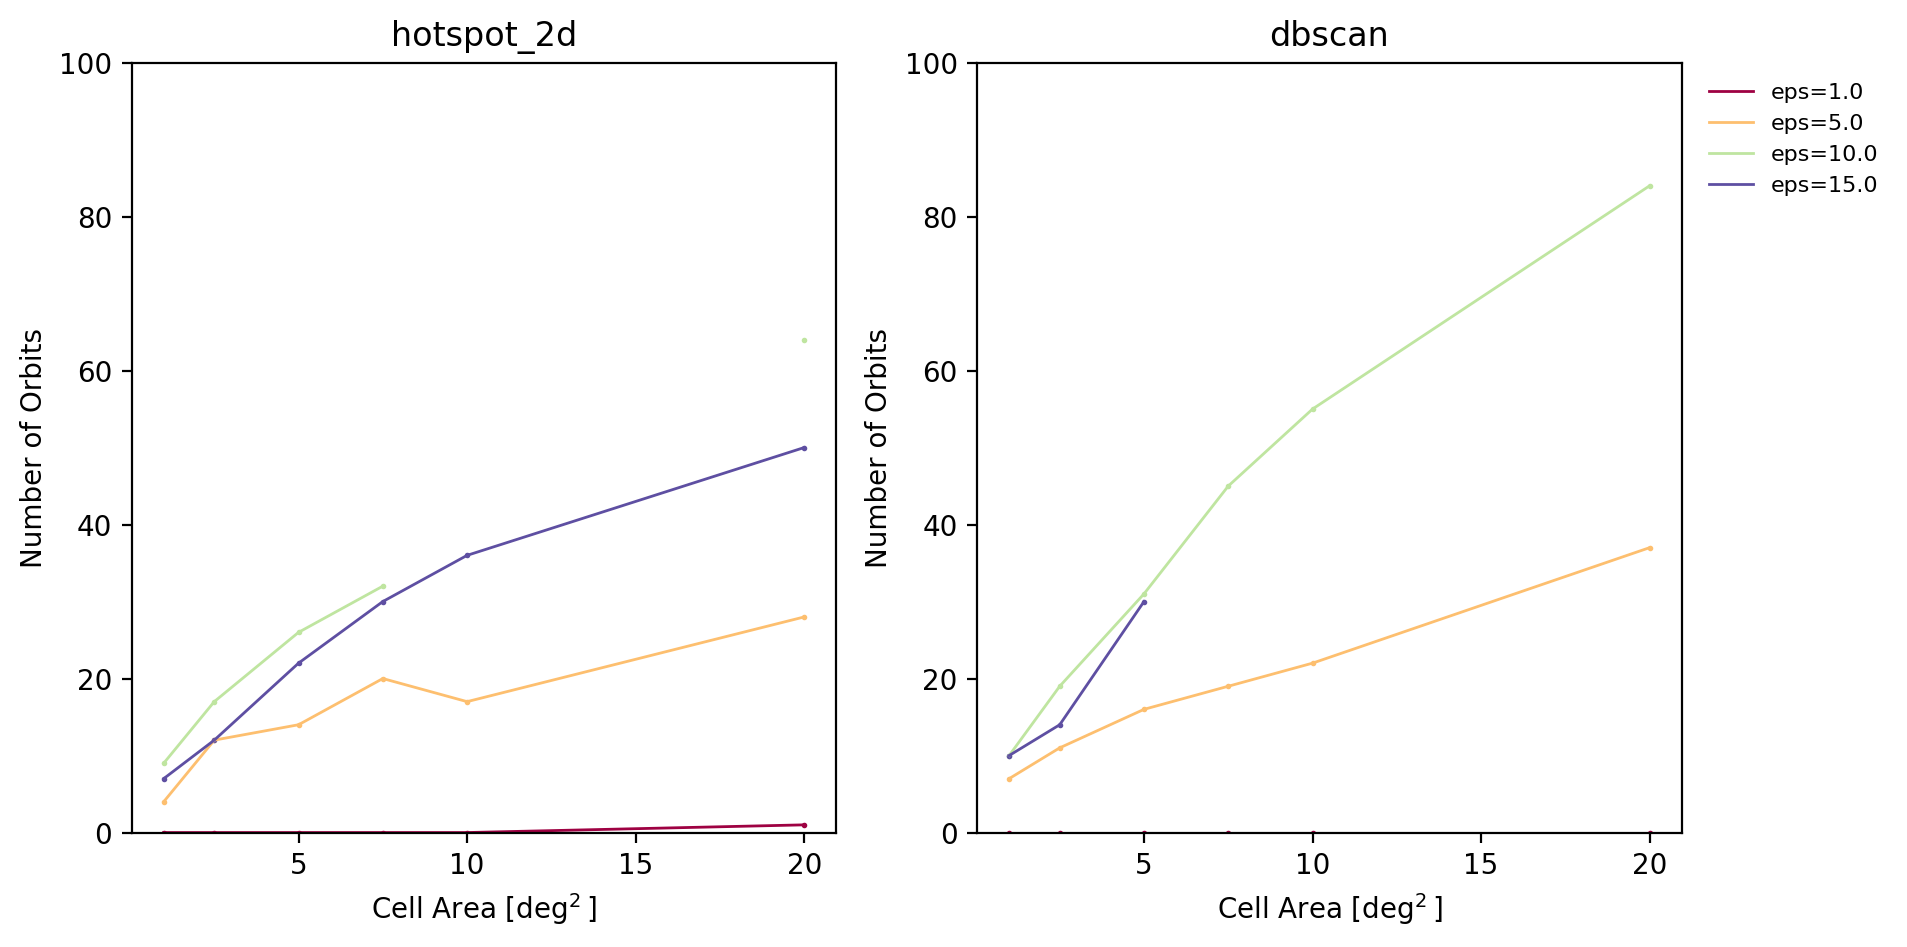

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
cmap = matplotlib.cm.get_cmap('Spectral')
rgba = cmap(np.linspace(0, 1, len(unique_eps)))
alpha_range = np.linspace(0.3, 1, len(unique_cell_area))

for i, eps in enumerate(unique_eps):
    for j, alg in enumerate(["hotspot_2d", "dbscan"]):
        mask_i = ((benchmark_results["alg"] == alg) 
            & (benchmark_results['eps'] == eps)
        )

        if j == 1:
            label = f"eps={eps}"
        else:
            label = None

        ax[j].scatter(
            benchmark_results[mask_i]["cell_area"].values, 
            benchmark_results[mask_i]["odp_orbits"].values, 
            c=rgba[i], 
            s=1
        )
        ax[j].plot(
            benchmark_results[mask_i]["cell_area"].values, 
            benchmark_results[mask_i]["odp_orbits"].values, 
            label=label, 
            c=rgba[i], 
            lw=1
        )
        ax[j].set_title(alg)

for a in ax:
    a.set_ylabel("Number of Orbits")
    a.set_xlabel("Cell Area [$\deg^2$]")
    a.set_ylim(0, 100)

ax[1].legend(frameon=False, bbox_to_anchor=(1.01, 1), fontsize=8)
fig.savefig("plots/benchmarks_orbits.png", bbox_inches="tight", dpi=200)

/tmp/ipykernel_224671/586321517.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')
/tmp/ipykernel_224671/586321517.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[j].scatter(


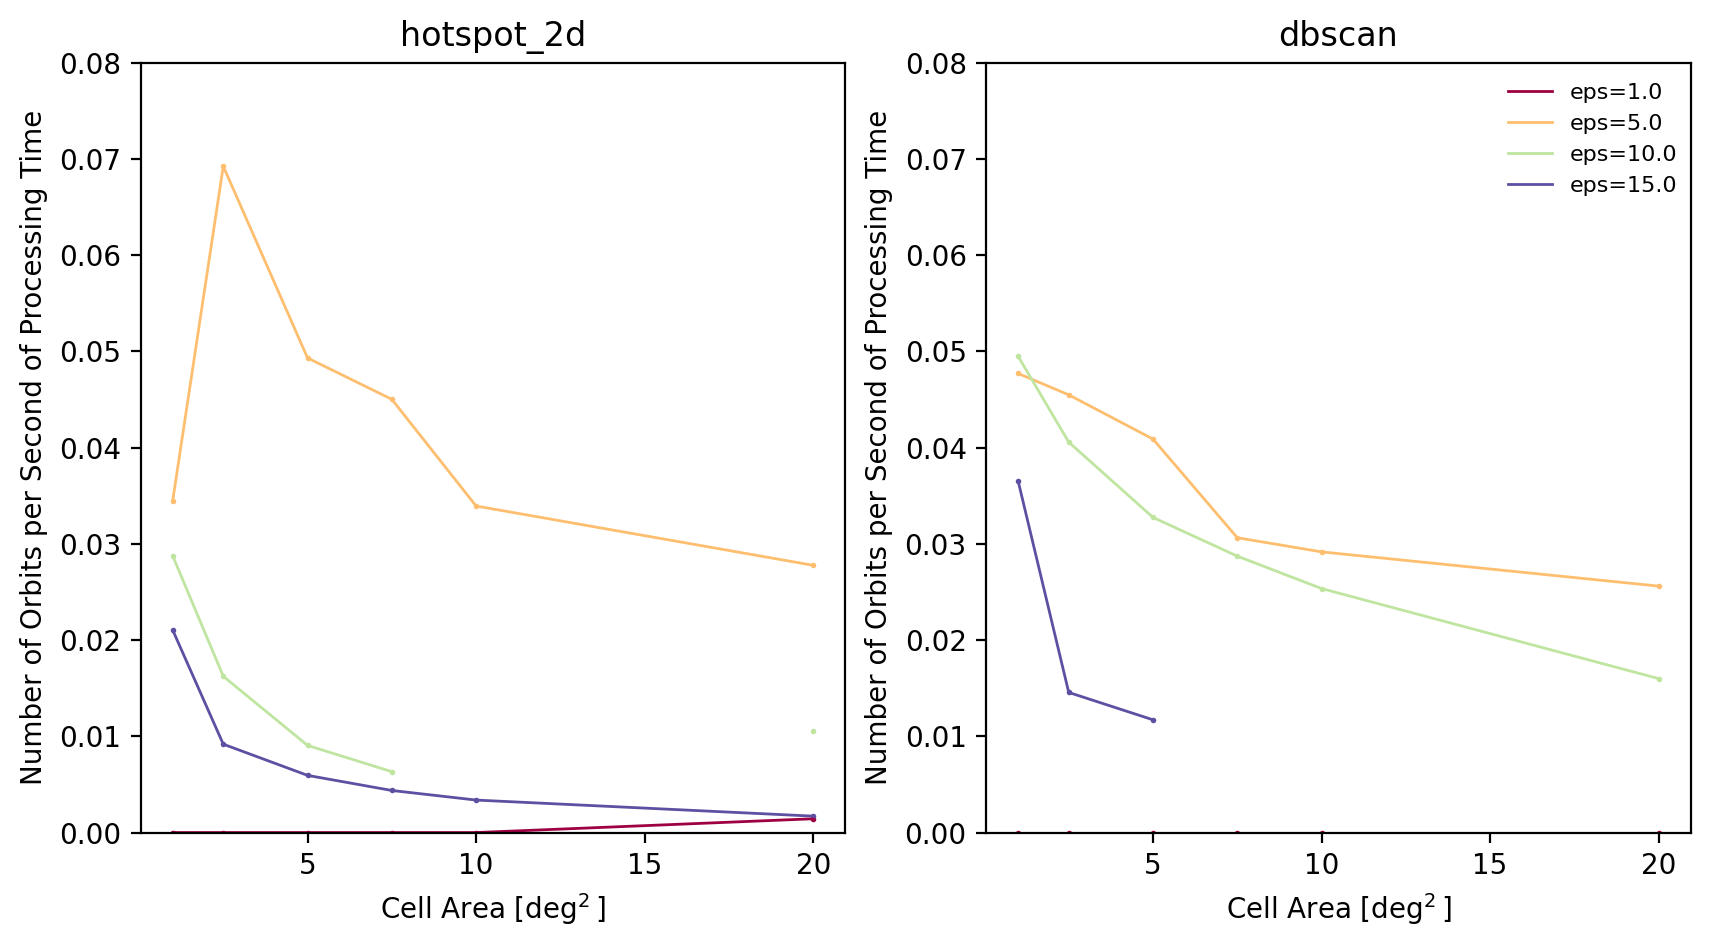

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
cmap = matplotlib.cm.get_cmap('Spectral')
rgba = cmap(np.linspace(0, 1, len(unique_eps)))
alpha_range = np.linspace(0.3, 1, len(unique_cell_area))

for i, eps in enumerate(unique_eps):
    for j, alg in enumerate(["hotspot_2d", "dbscan"]):
        mask_i = ((benchmark_results["alg"] == alg) 
            & (benchmark_results['eps'] == eps)
        )

        if j == 1:
            label = f"eps={eps}"
        else:
            label = None

        ax[j].scatter(
            benchmark_results[mask_i]["cell_area"].values, 
            benchmark_results[mask_i]["odp_orbits"].values / benchmark_results[mask_i]["total_time"].values, 
            c=rgba[i], 
            s=1
        )
        ax[j].plot(
            benchmark_results[mask_i]["cell_area"].values, 
            benchmark_results[mask_i]["odp_orbits"].values / benchmark_results[mask_i]["total_time"].values, 
            label=label, 
            c=rgba[i], 
            lw=1
        )
        ax[j].set_title(alg)

for a in ax:
    a.set_ylabel("Number of Orbits per Second of Processing Time")
    a.set_xlabel("Cell Area [$\deg^2$]")
    a.set_ylim(0, 0.08)

ax[1].legend(frameon=False, bbox_to_anchor=(1.01, 1), fontsize=8)
fig.savefig("plots/benchmarks_orbits_times.png", bbox_inches="tight", dpi=200)

In [10]:
# Calculate summary statistics for each month

# Calculate the number of observations per month
observations_per_month = frames.groupby(by=["dataset_id", "month"])["num_obs"].sum()
observations_per_month = observations_per_month.reset_index()

# Calculate the number of unique healpixels and exposures per month
results_per_month = frames.groupby(by=["dataset_id", "month"])[["healpixel", "exposure_id"]].nunique()
results_per_month.reset_index(inplace=True)

# Merge the two dataframes
results_per_month = results_per_month.merge(observations_per_month, on=["dataset_id", "month"])
results_per_month.rename(
    columns={"healpixel" : "num_healpixels", "exposure_id" : "num_exposures"},
    inplace=True
)
results_per_month["area_covered"] = hp.nside2pixarea(32, degrees=True) * results_per_month["num_healpixels"]
results_per_month.head()

results_per_month.sort_values(by=["dataset_id", "month"], inplace=True, ignore_index=True)

/tmp/ipykernel_224671/1370649062.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=4)


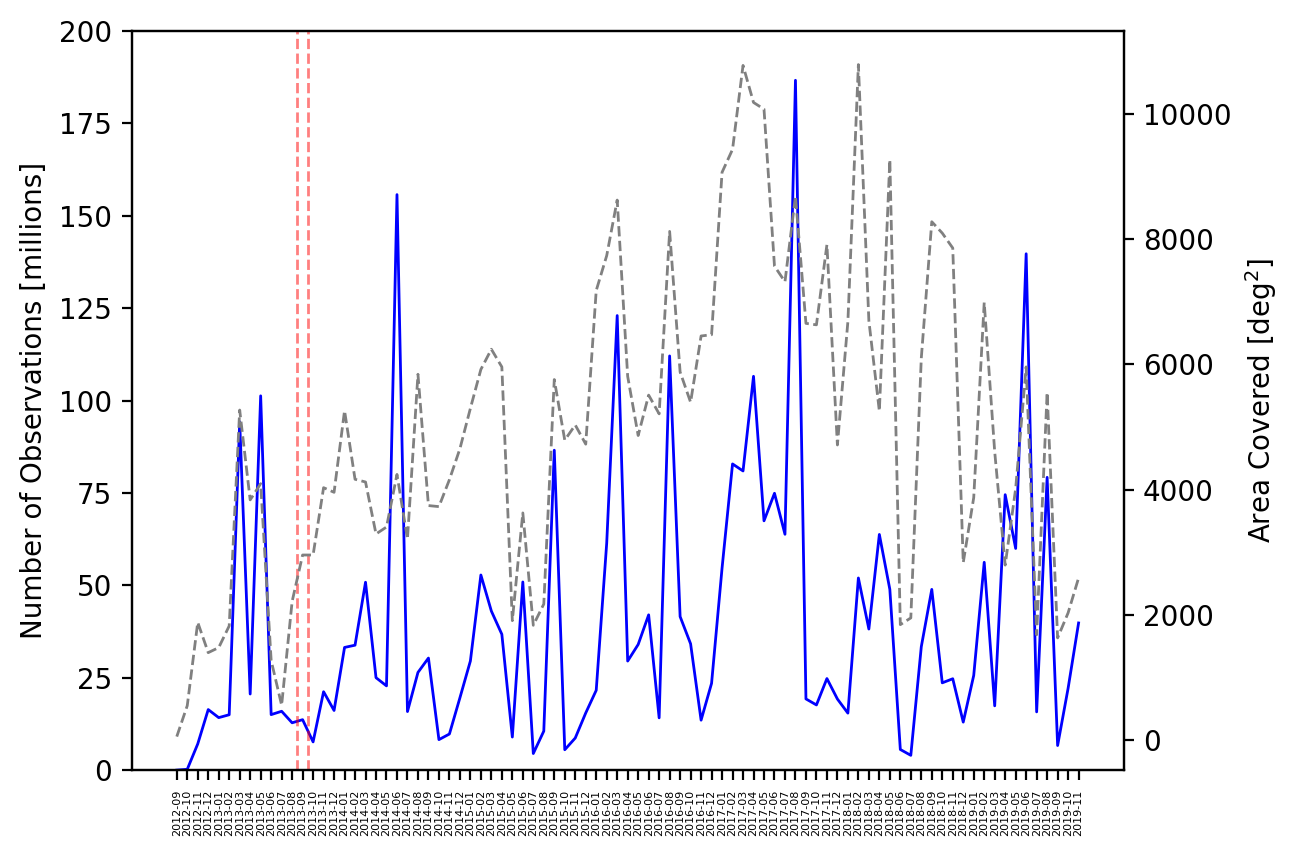

In [11]:
fig, ax = plt.subplots(1, 1, dpi=200)

for dataset_id in ["nsc"]:
    mask = (results_per_month["dataset_id"] == dataset_id)
    ax.plot(
        results_per_month[mask]["month"], 
        results_per_month[mask]["num_obs"] / 10**6, 
        lw=1,
        c="blue"
    )
    ax.set_ylim(0, 200)
    ax.set_ylabel("Number of Observations [millions]")
    ax2 = ax.twinx()
    ax2.plot(results_per_month[mask]["month"], results_per_month[mask]["area_covered"], c="gray", lw=1, ls="--")
    ax2.set_ylabel("Area Covered [deg$^2$]")
    ax.axvline(11.5, c="red", ls="--", label="Sample Data", lw=1, alpha=0.5)
    ax.axvline(12.5, c="red", ls="--", label="Sample Data", lw=1, alpha=0.5)
    
    labels = results_per_month[mask]["month"].values
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=4)

fig.savefig("plots/observations_per_month.png", bbox_inches="tight", dpi=200)

In [12]:
visits_per_healpixel = frames.groupby(["dataset_id", "month", "healpixel"])["exposure_id"].nunique().reset_index()
visits_per_healpixel = visits_per_healpixel.merge(frames.groupby(["dataset_id", "month", "healpixel"])["num_obs"].sum().reset_index(), on=["dataset_id", "month", "healpixel"], how="left")
visits_per_healpixel.rename(columns={"exposure_id" : "num_visits"}, inplace=True)
visits_per_healpixel_grouped = visits_per_healpixel.groupby(["dataset_id", "month"])["num_visits"].describe()

for p in [90, 95, 99]:
    visits_per_healpixel_grouped[f"{p:d}%"] = visits_per_healpixel.groupby(["dataset_id", "month"])["num_visits"].apply(lambda x: np.percentile(x, p))

visits_per_healpixel = visits_per_healpixel_grouped.reset_index()
# del visits_per_healpixel_grouped

/tmp/ipykernel_224671/650694344.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_224671/650694344.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=4)


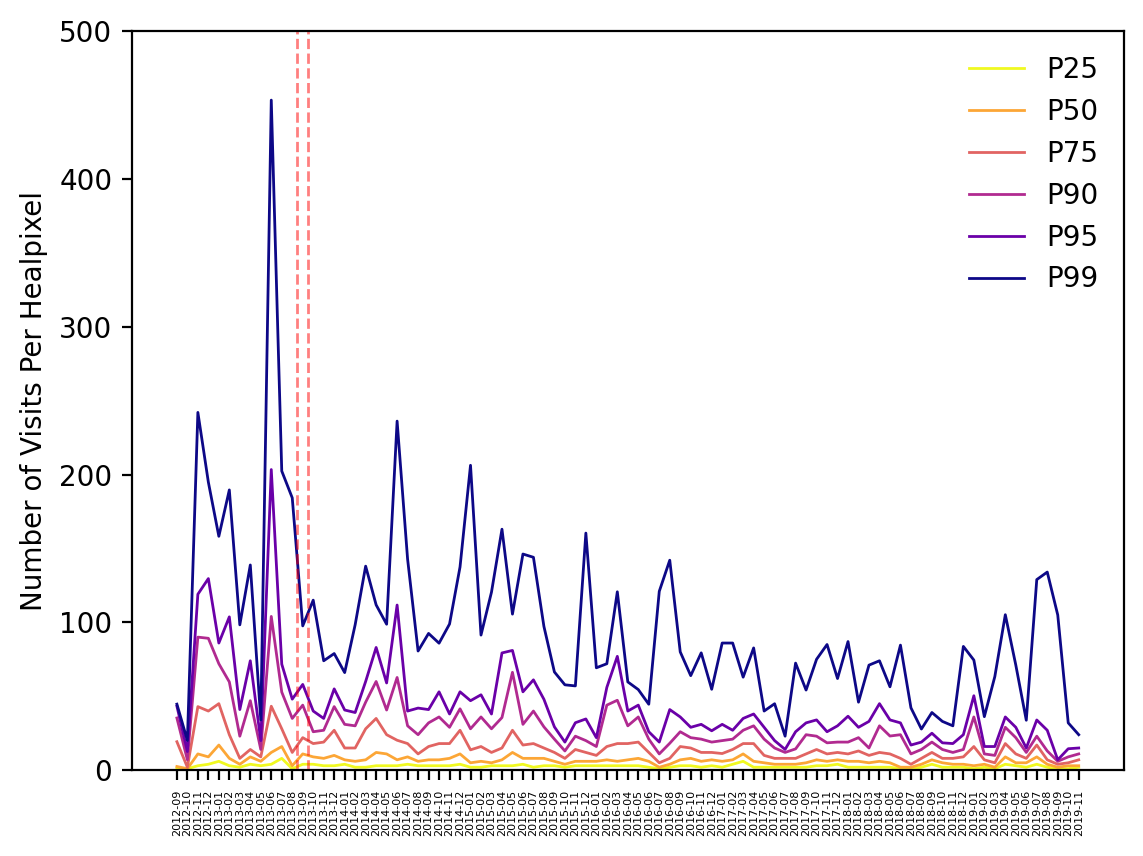

In [13]:
fig, ax = plt.subplots(1, 1, dpi=200)

percentiles = [25, 50, 75, 90, 95, 99]
cmap = matplotlib.cm.get_cmap('plasma')
rgba = cmap(np.linspace(1, 0, len(percentiles)))

for dataset_id in ["nsc"]:
    mask = (visits_per_healpixel["dataset_id"] == dataset_id)
    for i, p in enumerate(percentiles):
        ax.plot(
            visits_per_healpixel[mask]["month"], 
            visits_per_healpixel[mask][f"{p:d}%"], 
            lw=1,
            c=rgba[i],
            label=f"P{p:d}"
        )
    ax.set_ylim(0, 500)
    ax.set_ylabel("Number of Visits Per Healpixel")
    ax.axvline(11.5, c="red", ls="--", lw=1, alpha=0.5)
    ax.axvline(12.5, c="red", ls="--", lw=1, alpha=0.5)
    ax.legend(frameon=False)
    labels = results_per_month[mask]["month"].values
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=4)

fig.savefig("plots/visits_per_healpixel.png", bbox_inches="tight", dpi=200)

In [14]:
num_obs_per_healpixel = frames.groupby(["dataset_id", "month", "healpixel"])["num_obs"].sum().reset_index()
num_obs_per_healpixel = num_obs_per_healpixel.merge(frames.groupby(["dataset_id", "month", "healpixel"])["exposure_id"].nunique().reset_index(), on=["dataset_id", "month", "healpixel"], how="left")
num_obs_per_healpixel.rename(columns={"exposure_id" : "num_visits"}, inplace=True)
num_obs_per_healpixel = num_obs_per_healpixel.merge(visits_per_healpixel, on=["dataset_id", "month"], how="left")
num_obs_per_healpixel

,dataset_id,month,healpixel,num_obs,num_visits,count,mean,std,min,25%,50%,75%,max,90%,95%,99%
0,nsc,2012-09,4351,679,2,18.0,11.166667,15.166721,1.0,1.25,2.5,19.25,45.0,35.3,43.3,44.66
1,nsc,2012-09,4499,341,23,18.0,11.166667,15.166721,1.0,1.25,2.5,19.25,45.0,35.3,43.3,44.66
2,nsc,2012-09,4502,609,32,18.0,11.166667,15.166721,1.0,1.25,2.5,19.25,45.0,35.3,43.3,44.66
3,nsc,2012-09,4504,36,3,18.0,11.166667,15.166721,1.0,1.25,2.5,19.25,45.0,35.3,43.3,44.66
4,nsc,2012-09,4505,1549,43,18.0,11.166667,15.166721,1.0,1.25,2.5,19.25,45.0,35.3,43.3,44.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554443,ztf,2023-06,12283,169,15,5832.0,13.543896,10.475513,1.0,5.00,12.0,18.00,74.0,29.0,35.0,46.00
554444,ztf,2023-06,12284,172,25,5832.0,13.543896,10.475513,1.0,5.00,12.0,18.00,74.0,29.0,35.0,46.00
554445,ztf,2023-06,12285,137,29,5832.0,13.543896,10.475513,1.0,5.00,12.0,18.00,74.0,29.0,35.0,46.00
554446,ztf,2023-06,12286,107,15,5832.0,13.543896,10.475513,1.0,5.00,12.0,18.00,74.0,29.0,35.0,46.00


/tmp/ipykernel_224671/3076771179.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')
/tmp/ipykernel_224671/3076771179.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=4)


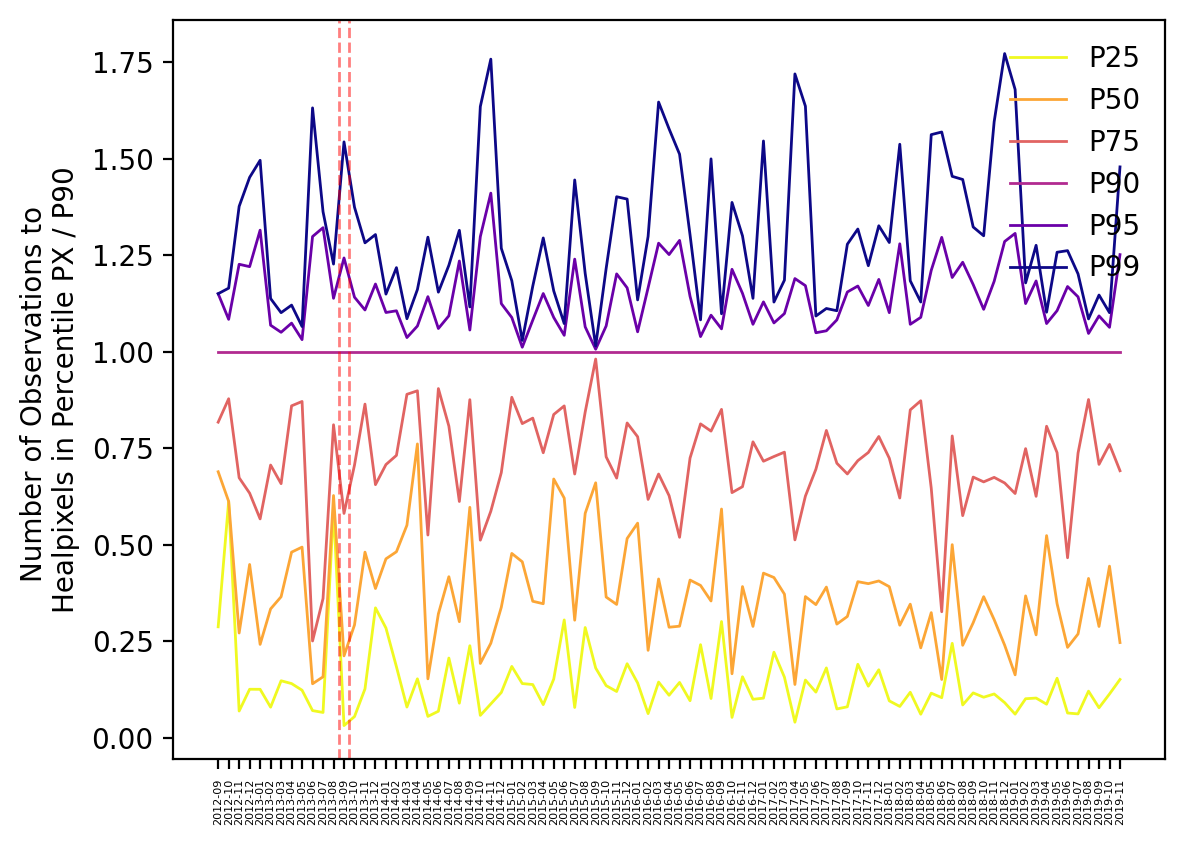

In [15]:
fig, ax = plt.subplots(1, 1, dpi=200)

percentiles = [25, 50, 75, 90, 95, 99]
cmap = matplotlib.cm.get_cmap('plasma')
rgba = cmap(np.linspace(1, 0, len(percentiles)))

for dataset_id in ["nsc"]:
    for i, p in enumerate(percentiles):

        num_obs_per_healpixel_i = num_obs_per_healpixel[(
            (num_obs_per_healpixel["num_visits"] <= num_obs_per_healpixel[f"{p:d}%"]) 
            & (num_obs_per_healpixel["dataset_id"] == dataset_id))
        ].groupby(by=["dataset_id", "month"])["num_obs"].sum().reset_index()

        p90 = num_obs_per_healpixel[(
            (num_obs_per_healpixel["num_visits"] <= num_obs_per_healpixel[f"90%"]) 
            & (num_obs_per_healpixel["dataset_id"] == dataset_id))
        ].groupby(by=["dataset_id", "month"])["num_obs"].sum().reset_index()

        ax.plot(
            num_obs_per_healpixel_i["month"], 
            num_obs_per_healpixel_i["num_obs"] / p90["num_obs"], 
            lw=1,
            c=rgba[i],
            label=f"P{p:d}"
        )
    ax.set_ylabel("Number of Observations to \nHealpixels in Percentile PX / P90")
    ax.axvline(11.5, c="red", ls="--", lw=1, alpha=0.5)
    ax.axvline(12.5, c="red", ls="--", lw=1, alpha=0.5)
    ax.legend(frameon=False)
    labels = results_per_month[mask]["month"].values
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=4)

fig.savefig("plots/observations_per_healpixel_visit_percentile.png", bbox_inches="tight", dpi=200)